In [12]:
#################### 2020 xilinx summer school ############

import sys
import numpy as np 
import os
import time
import math
from PIL import Image,ImageDraw
from matplotlib import pyplot
import matplotlib.pylab as plt
import cv2
from datetime import datetime
from pynq import Xlnk
from pynq import Overlay
from summer_processing import *
import struct

team = 'summernet'
agent = Agent(team)
interval_time = 0

xlnk = Xlnk()
xlnk.xlnk_reset()

img = xlnk.cma_array(shape=(3,162,322), dtype=np.uint8)

conv_weight_1x1_all = xlnk.cma_array(shape=(1181, 16, 16), dtype=np.uint16)
conv_weight_3x3_all = xlnk.cma_array(shape=(46, 16, 3, 3), dtype=np.uint16)
bias_all = xlnk.cma_array(shape=(123, 16), dtype=np.uint16)
DDR_pool_3_out = xlnk.cma_array(shape=(48, 82, 162), dtype=np.uint16)
DDR_pool_6_out = xlnk.cma_array(shape=(96, 42, 82), dtype=np.uint16)
DDR_buf = xlnk.cma_array(shape=(36, 16, 22, 42), dtype=np.uint16)
predict_box = xlnk.cma_array(shape=(5,), dtype=np.float32)

print("Allocating memory successfully ")

path_mkdir()

img_path = '/home/xilinx/jupyter_notebooks/summer_school/images/'
coord_path = '/home/xilinx/jupyter_notebooks/summer_school/result/coordinate/summer_school/'

tbatch = 0
total_num_img = len(agent.img_list)
print("total_num_img:", total_num_img)
result = list()
agent.reset_batch_count()        
        
blank = Image.new('RGB', (322, 162), (127, 127, 127))

# load parameters from SD card to DDR
params = np.fromfile("summernet.bin", dtype=np.uint16)
idx = 0

np.copyto(conv_weight_1x1_all, params[idx:idx+conv_weight_1x1_all.size].reshape(conv_weight_1x1_all.shape))
idx += conv_weight_1x1_all.size

np.copyto(conv_weight_3x3_all, params[idx:idx+conv_weight_3x3_all.size].reshape(conv_weight_3x3_all.shape))
idx += conv_weight_3x3_all.size

np.copyto(bias_all, params[idx:idx+bias_all.size].reshape(bias_all.shape))

print("Parameters loading successfully")


Allocating memory successfully 
total_num_img: 16
Parameters loading successfully


In [9]:
################### download the overlay #####################
overlay = Overlay('/home/xilinx/jupyter_notebooks/summer_school/overlay/summernet/summernet.bit')

print("summernet.bit loaded successfully")
myIP = overlay.mobilenet_0

summernet.bit loaded successfully


currPic: 0.jpg
currPic: 1.jpg
predict_box: [ 0.49492186  0.49101561  0.05719239  0.165005    0.8359375 ]
coordinate[x1, x2, y1, y2]: [298, 335, 147, 206]
batch[i]: 1.jpg
[x1, x2, y1, y2] [298, 335, 147, 206]


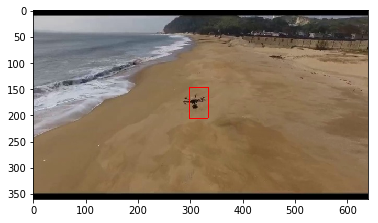

predict_box [ 0.48222655  0.48320311  0.06507093  0.11338333  0.828125  ]
All computation finish


In [30]:
################## download weights and image resizing and processing

myIP.write(0x10, img.physical_address)

myIP.write(0x18, conv_weight_1x1_all.physical_address)
myIP.write(0x20, conv_weight_3x3_all.physical_address)
myIP.write(0x28, bias_all.physical_address)

myIP.write(0x30, DDR_pool_3_out.physical_address)
myIP.write(0x38, DDR_pool_6_out.physical_address)

myIP.write(0x40, DDR_buf.physical_address)
myIP.write(0x48, predict_box.physical_address)



def process_image(currPic):
    print("img_path + currPic:", img_path + currPic)
    image = Image.open(img_path + currPic).convert('RGB')
    image = image.resize((320, 160))
    blank.paste(image, (1, 1))
    image = np.transpose(blank, (2, 0, 1))
    np.copyto(img, np.array(image))
    

first_image = True
boxes = []
names = []

i = 0
lastimgname="x.jpg"

################### Start to detect ################
start = time.time()
for batch in get_image_batch():
    for currPic in batch:
        i=i+1
        print("currPic:", currPic)
        names.append(currPic)

        if first_image:
            image = Image.open(img_path + currPic).convert('RGB')
            image = image.resize((320, 160))
            blank.paste(image, (1, 1))
            image = np.transpose(blank, (2, 0, 1))
            np.copyto(img, np.array(image))
#             image_1 = pyplot.imread(img_path + currPic)
#             pyplot.imshow(image_1)
#             pyplot.show()
            

            first_image = False
            continue
            
        if not first_image:
            myIP.write(0x00, 1)
            time.sleep(0.07)
            image = Image.open(img_path + currPic).convert('RGB')
            image = image.resize((320, 160))
            blank.paste(image, (1, 1))
            image = np.transpose(blank, (2, 0, 1))
            np.copyto(img, np.array(image))
#             image_show = pyplot.imread(img_path + currPic)
#             pyplot.imshow(image_show)
#             pyplot.show()
        
        isready = myIP.read(0x00)
        while( isready == 1 ):
            isready = myIP.read(0x00)
            
        predict_box[0] = predict_box[0] / 40;
        predict_box[1] = predict_box[1] / 20;
        predict_box[2] = predict_box[2] / 40;
        predict_box[3] = predict_box[3] / 20;
        print("predict_box:", predict_box)
        x1 = int(round((predict_box[0] - predict_box[2]/2.0) * 640))
        y1 = int(round((predict_box[1] - predict_box[3]/2.0) * 360))
        x2 = int(round((predict_box[0] + predict_box[2]/2.0) * 640))
        y2 = int(round((predict_box[1] + predict_box[3]/2.0) * 360))
        boxes.append([x1, x2, y1, y2])
        print("coordinate[x1, x2, y1, y2]:", [x1, x2, y1, y2])
        
        
        ###########在原图上画出边界框########
        print("batch[i]:", batch[i-1])
        print("[x1, x2, y1, y2]", [x1, x2, y1, y2])       
        imgee=Image.open(img_path+batch[i-1]).convert('RGB')
        # image = image.resize((320, 160))
        image_show=np.array(imgee)
        for x in range(x1,x2):
            image_show[y1][x][0]=255
            image_show[y1][x][1]=0
            image_show[y1][x][2]=0
            image_show[y1+1][x][0]=255
            image_show[y1+1][x][1]=0
            image_show[y1+1][x][2]=0
        for x in range(x1,x2):
            image_show[y2][x][0]=255
            image_show[y2][x][1]=0
            image_show[y2][x][2]=0
            image_show[y2+1][x][0]=255
            image_show[y2+1][x][1]=0
            image_show[y2+1][x][2]=0
        for y in range(y1,y2):
            image_show[y][x1][0]=255
            image_show[y][x1][1]=0
            image_show[y][x1][2]=0
            image_show[y][x1+1][0]=255
            image_show[y][x1+1][1]=0
            image_show[y][x1+1][2]=0
        for y in range(y1,y2):
            image_show[y][x2][0]=255
            image_show[y][x2][1]=0
            image_show[y][x2][2]=0
            image_show[y][x2+1][0]=255
            image_show[y][x2+1][1]=0
            image_show[y][x2+1][2]=0
        pyplot.imshow(image_show)
        pyplot.show()
        #image_show.close()
        #lastimgname=batch[i-1]
        ###################

        

#collect result for last image
myIP.write(0x00, 1)
isready = myIP.read(0x00)
while( isready == 1 ):
    isready = myIP.read(0x00)   
    
predict_box[0] = predict_box[0] / 40;
predict_box[1] = predict_box[1] / 20;
predict_box[2] = predict_box[2] / 40;
predict_box[3] = predict_box[3] / 20;
print("predict_box", predict_box)
x1 = int(round((predict_box[0] - predict_box[2]/2.0) * 640))
y1 = int(round((predict_box[1] - predict_box[3]/2.0) * 360))
x2 = int(round((predict_box[0] + predict_box[2]/2.0) * 640))
y2 = int(round((predict_box[1] + predict_box[3]/2.0) * 360))
boxes.append([x1, x2, y1, y2])

#####################在原图上画出边界框##########
# print("lastimgname:", lastimgname)
# print("[x1, x2, y1, y2]", [x1, x2, y1, y2])       
# imgee=Image.open(img_path+batch[i-1]).convert('RGB')
# image_show=np.array(imgee)
# for x in range(x1,x2):
#     image_show[y1][x][0]=255
#     image_show[y1][x][1]=0
#     image_show[y1][x][2]=0
#     image_show[y1+1][x][0]=255
#     image_show[y1+1][x][1]=0
#     image_show[y1+1][x][2]=0
# for x in range(x1,x2):
#     image_show[y2][x][0]=255
#     image_show[y2][x][1]=0
#     image_show[y2][x][2]=0
#     image_show[y2+1][x][0]=255
#     image_show[y2+1][x][1]=0
#     image_show[y2+1][x][2]=0
# for y in range(y1,y2):
#     image_show[y][x1][0]=255
#     image_show[y][x1][1]=0
#     image_show[y][x1][2]=0
#     image_show[y][x1+1][0]=255
#     image_show[y][x1+1][1]=0
#     image_show[y][x1+1][2]=0
# for y in range(y1,y2):
#     image_show[y][x2][0]=255
#     image_show[y][x2][1]=0
#     image_show[y][x2][2]=0
#     image_show[y][x2+1][0]=255
#     image_show[y][x2+1][1]=0
#     image_show[y][x2+1][2]=0
# pyplot.imshow(image_show)
# pyplot.show()
#image_show.close()
###################
    
        
        
end = time.time()
tbatch = end - start

        
print("All computation finish")


In [33]:
################ record the results and write to XML
f_out = open(coord_path + '/summernet.txt', 'w')
cnt = 0
for box in boxes:
    x1 = box[0]
    x2 = box[1]
    y1 = box[2]
    y2 = box[3]
    coord = str(x1) + ' ' + str(x2) + ' ' + str(y1) + ' ' + str(y2)
    
    name = names[cnt]
    cnt = cnt + 1
    f_out.write(name + '\n')
    f_out.write(coord + '\n')
        
f_out.close()
print("\nAll results stored in summernet.txt sucessfully")

# agent.save_results_xml(boxes)
# agent.write(tbatch, total_num_img, team)

# print("XML and time results written successfully.")


All results stored in summernet.txt


In [34]:
############## clean up #############
xlnk.xlnk_reset()